In [146]:
'''
author: Felix Hol
date: 2021 Oct 11
content: process DeepLabCut detections for multiple animals that mainly move in one direction.
Use corner coordinates to rotate detections (includes filtering), use rotated detections to assign to
specific Y-track. Use x-coordinate and temperature callibration to calculate corresponding temperature. 
'''

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import os
from tqdm.notebook import tnrange, tqdm
import glob
import math
import deeplabcut
import pickle
import warnings
import seaborn as sns
import cv2
warnings.simplefilter('ignore')

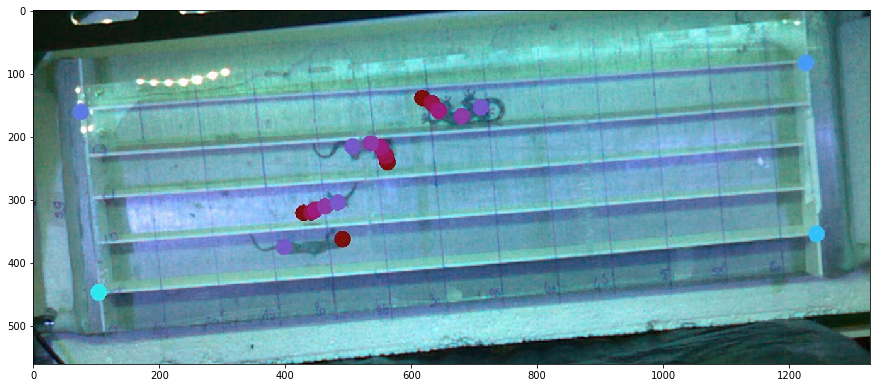

In [151]:
exampleImage = cv2.imread('/home/felix/Desktop/Screenshot from 2021-10-11 22-18-05.png', cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(15,9))
plt.imshow(exampleImage)

Above is a still of the video I'm working with in this notebook. The animals are visble with DLC detected markers, markers show specific body parts but are not labelled according to individual (i.e. this is raw DLC output, animals have no identities assigned). The corners of the box are labelled as well. The box is clearly tilted (rotated) with respect to the field of view. Coordinates of the animals and box need to be rotated to align with the field of fiew as a reference. Next, we can use the x-coordinate as a measure for temperature. 

In [2]:
### Load DLC detections and a dataframe to steal the header for convenience

fullDLCpickle = '/home/felix/Dropbox/HongKong/12082019_64656667/12082019_64656667-1DLC_resnet50_lizNov2shuffle1_140000_full.pickle'
DLCdf = '/home/felix/Dropbox/HongKong/12082019_64656667/12082019_64656667-1DLC_resnet50_lizNov2shuffle1_140000.h5'

# fullDLCpickle = '/mnt/DATA/geckos/test_b8/021118_38394041shortDLC_resnet50_gekApr30shuffle1_180000_full.pickle'
# DLCdf = '/mnt/DATA/geckos/test_b8/021118_38394041shortDLC_resnet50_gekApr30shuffle1_180000_bx.h5'


In [3]:
g = pd.read_hdf(DLCdf)
f = pd.read_pickle(fullDLCpickle)

In [4]:
header = f.pop('metadata')

In [5]:
### create empty dataframe to move data to

df = pd.DataFrame(columns=g.columns, index=range(header['nframes']))
scorer = df.columns.get_level_values(0)[0]

In [6]:
### first get coordinates for all arena corners to use to assign animals to tracks

corners = df[scorer, 'single'].columns.get_level_values(0).unique()

scorer = df.columns.get_level_values(0)[0]
ind = 'single'

for bpt in tqdm(corners):
    bptN = header['all_joints_names'].index(bpt)
    frameNames = list(f)

    for i in range(header['nframes']):
        try:
            df[scorer, ind, bpt, 'x'].loc[i] = f[frameNames[i]]['coordinates'][0][bptN][0][0]
            df[scorer, ind, bpt, 'y'].loc[i] = f[frameNames[i]]['coordinates'][0][bptN][0][1]
            df[scorer, ind, bpt, 'likelihood'].loc[i] = f[frameNames[i]]['confidence'][bptN][0][0]
        except:
            pass
    

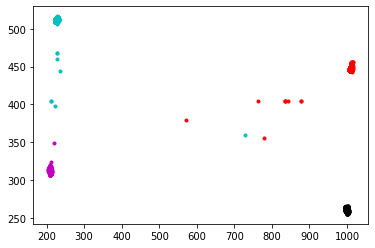

In [88]:
plt.plot(df[scorer, 'single', 'bottomrightcorner'].x, df[scorer, 'single', 'bottomrightcorner'].y, '.r')
plt.plot(df[scorer, 'single', 'bottomleftcorner'].x, df[scorer, 'single', 'bottomleftcorner'].y, '.c')
plt.plot(df[scorer, 'single', 'toprightcorner'].x, df[scorer, 'single', 'toprightcorner'].y, '.k')
plt.plot(df[scorer, 'single', 'topleftcorner'].x, df[scorer, 'single', 'topleftcorner'].y, '.m')


### Raw corner coordinates, some errors are obvious

In [11]:
#### Interpolate (fill NaN), and rolling mean (window) of corners, add _filt columns

window = 200

for corner in corners:
    df[scorer, 'single', corner + '_filt', 'x'] = df[scorer, 'single', corner].x.interpolate(limit_area='inside').rolling(window, min_periods=1).mean()
    df[scorer, 'single', corner + '_filt', 'y'] = df[scorer, 'single', corner].y.interpolate(limit_area='inside').rolling(window, min_periods=1).mean()
    

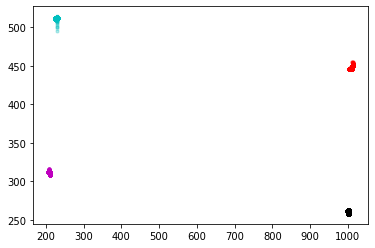

In [89]:
plt.plot(df[scorer, 'single', 'bottomrightcorner_filt'].x, df[scorer, 'single', 'bottomrightcorner_filt'].y, '.r', alpha = 0.1)
plt.plot(df[scorer, 'single', 'bottomleftcorner_filt'].x, df[scorer, 'single', 'bottomleftcorner_filt'].y, '.c', alpha = 0.1)
plt.plot(df[scorer, 'single', 'toprightcorner_filt'].x, df[scorer, 'single', 'toprightcorner_filt'].y, '.k', alpha = 0.1)
plt.plot(df[scorer, 'single', 'topleftcorner_filt'].x, df[scorer, 'single', 'topleftcorner_filt'].y, '.m', alpha = 0.1)

### Filtered corners, large errors are gone

In [13]:
###calculate angles, interpolate, and rolling mean (window)

window = 2000

df[scorer, 'single', 'angle', 'angle1'] = \
np.arctan((df[scorer, 'single', 'bottomrightcorner_filt'].y - df[scorer, 'single', 'bottomleftcorner_filt'].y) / \
(df[scorer, 'single', 'bottomrightcorner_filt'].x - df[scorer, 'single', 'bottomleftcorner_filt'].x))

df[scorer, 'single', 'angle', 'angle1'] = df[scorer, 'single', 'angle', 'angle1'].rolling(window, min_periods=1).mean()

df[scorer, 'single', 'angle', 'angle2'] = \
np.arctan((df[scorer, 'single', 'toprightcorner_filt'].y - df[scorer, 'single', 'topleftcorner_filt'].y) / \
(df[scorer, 'single', 'toprightcorner_filt'].x - df[scorer, 'single', 'topleftcorner_filt'].x))

df[scorer, 'single', 'angle', 'angle2'] = df[scorer, 'single', 'angle', 'angle2'].rolling(window, min_periods=1).mean()

### average angle

df[scorer, 'single', 'angle', 'angleM'] = np.nanmean([df[scorer, 'single', 'angle', 'angle1'], df[scorer, 'single', 'angle', 'angle2']], axis=0)

/home/felix/anaconda3/envs/dlc-gpu3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### Rotation

$x' = x \cos{\theta} +  y \sin{\theta}$  
$y' = -x \sin{\theta} +  y \cos{\theta}$

In [14]:
### perform rotation

for corner in corners:
    df[scorer, 'single', corner + '_rot', 'x'] = \
    (df[scorer, 'single', corner + '_filt'].x * np.cos(df[scorer, 'single', 'angle'].angleM)) + \
    (df[scorer, 'single', corner + '_filt'].y * np.sin(df[scorer, 'single', 'angle'].angleM))

    df[scorer, 'single', corner + '_rot', 'y'] = \
    (-1 * df[scorer, 'single', corner + '_filt'].x * np.sin(df[scorer, 'single', 'angle'].angleM)) + \
    (df[scorer, 'single', corner + '_filt'].y * np.cos(df[scorer, 'single', 'angle'].angleM))

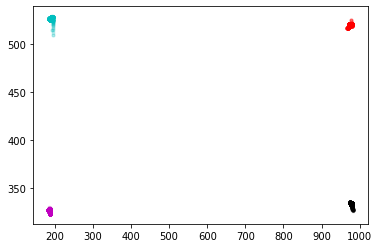

In [90]:
plt.plot(df[scorer, 'single', 'bottomrightcorner_rot'].x, df[scorer, 'single', 'bottomrightcorner_rot'].y, '.r', alpha = 0.1)
plt.plot(df[scorer, 'single', 'bottomleftcorner_rot'].x, df[scorer, 'single', 'bottomleftcorner_rot'].y, '.c', alpha = 0.1)
plt.plot(df[scorer, 'single', 'toprightcorner_rot'].x, df[scorer, 'single', 'toprightcorner_rot'].y, '.k', alpha = 0.1)
plt.plot(df[scorer, 'single', 'topleftcorner_rot'].x, df[scorer, 'single', 'topleftcorner_rot'].y, '.m', alpha = 0.1)

### Filtered and rotated corner coordinates *ready for use*

### Animal rotations have to be done on dictionary, combine with assignment to correct track

$x' = x \cos{\theta} +  y \sin{\theta}$  
$y' = -x \sin{\theta} +  y \cos{\theta}$

In [41]:
nAnimals = 4
nBpts = 5 
individuals = df[scorer].columns.get_level_values(0).unique()[0:nAnimals]
top = df[scorer, 'single', 'toprightcorner_rot'].y.mean()
bottom = df[scorer, 'single', 'bottomrightcorner_rot'].y.mean()
bottomCorrection = 15
trackYs = np.linspace(top, bottom - bottomCorrection, nAnimals + 1)

scorer = df.columns.get_level_values(0)[0]
bpt = 'head'
bptN = header['all_joints_names'].index(bpt)
frameNames = list(f)

for i in tnrange(header['nframes']):
    try:
        j = 0
        for coor in f[frameNames[i]]['coordinates'][0][bptN]:
            x = coor[0] * np.cos(df.iloc[i][scorer, 'single', 'angle'].angleM) + \
            coor[1] * np.sin(df.iloc[i][scorer, 'single', 'angle'].angleM)
            y = -1 * coor[0] * np.sin(df.iloc[i][scorer, 'single', 'angle'].angleM) + \
            coor[1] * np.cos(df.iloc[i][scorer, 'single', 'angle'].angleM)
            c = f[frameNames[i]]['confidence'][0][j][0]
            j = j +1
            if y > top + 15:
                indN = next(x for x, val in enumerate(trackYs) if val > y)
                ind = individuals[indN - 1]
                df[scorer, ind, bpt, 'x'].loc[i] = x
                df[scorer, ind, bpt, 'y'].loc[i] = y
                df[scorer, ind, bpt, 'likelihood'].loc[i] = c
    except:
        pass

/home/felix/anaconda3/envs/dlc-gpu3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


/home/felix/anaconda3/envs/dlc-gpu3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Text(0.5, 0, 'x coordinate')

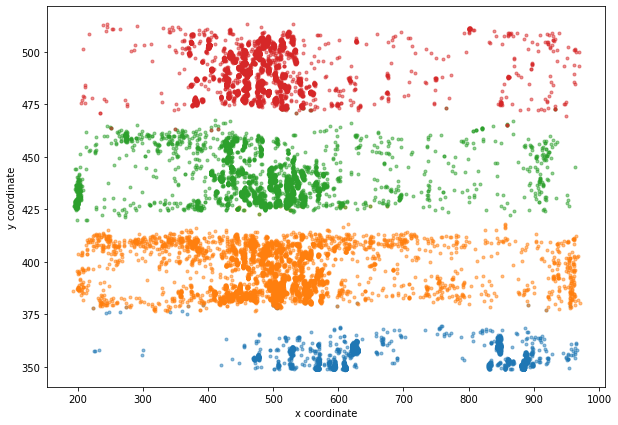

In [91]:
plt.figure(figsize=(10,7))

plt.plot(df[scorer, 'liz1', 'head'].x, df[scorer, 'liz1', 'head'].y, '.', alpha=0.5)
plt.plot(df[scorer, 'liz2', 'head'].x, df[scorer, 'liz2', 'head'].y, '.', alpha=0.5)
plt.plot(df[scorer, 'liz3', 'head'].x, df[scorer, 'liz3', 'head'].y, '.', alpha=0.5)
plt.plot(df[scorer, 'liz4', 'head'].x, df[scorer, 'liz4', 'head'].y, '.', alpha=0.5)

plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

These are the head coordinates of the 4 animals in this experiment. Each animal is labelled in a single color. Points of a single color form a single cloud (in the Y direction) which means that all coordinates of one individual are correctly assigned to that individual. 

In [72]:
positions = [0,
5,
10,
15,
20,
25,
30,
35,
40,
45,
50,
55,
60,
65
]

temp_grad = [39.124,
37.137,
35.5,
34.089,
32.09,
30.662,
29.3,
27.152,
25.5,
23.652,
22.098,
20.115,
18.641,
17.149]

Text(0, 0.5, 'temperature (C)')

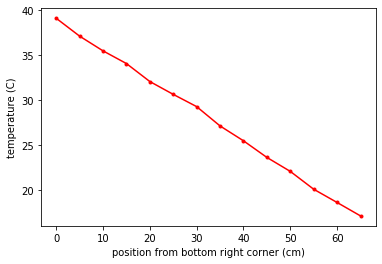

In [77]:
plt.plot(positions, temp_grad, '.-r')
plt.xlabel('position from bottom right corner (cm)')
plt.ylabel('temperature (C)')

Linear enough for a first approximation

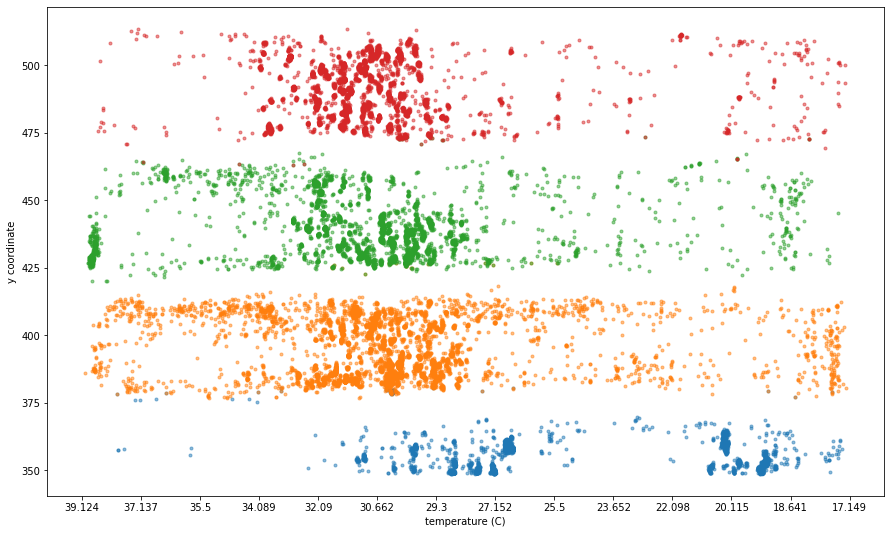

In [92]:
plt.figure(figsize=(15,9))

plt.plot(df[scorer, 'liz1', 'head'].x, df[scorer, 'liz1', 'head'].y, '.', alpha=0.5)
plt.plot(df[scorer, 'liz2', 'head'].x, df[scorer, 'liz2', 'head'].y, '.', alpha=0.5)
plt.plot(df[scorer, 'liz3', 'head'].x, df[scorer, 'liz3', 'head'].y, '.', alpha=0.5)
plt.plot(df[scorer, 'liz4', 'head'].x, df[scorer, 'liz4', 'head'].y, '.', alpha=0.5)

plt.ylabel('y coordinate')
plt.xlabel('temperature (C)')
x_left = np.mean(df[scorer, 'single', 'bottomleftcorner_rot'].x)
x_right = np.mean(df[scorer, 'single', 'bottomrightcorner_rot'].x)
_=plt.xticks(np.linspace(x_left, x_right, 14), temp_grad)


### Above the x-axis shows temperature in centigrade. Apparently, these fine animals like hanging around at around 30C.

### Temperature callibration:  

$T_{x} = \frac{-0.34 * 65}{x_{r} - x_{l}} * (x - x_{l}) + 39.12$

where $x_{l}$ is the x coordinate of the bottom left corner, and $x_{r}$ the x of the bottom right.

In [108]:
for ind in individuals:
    df[scorer, ind, 'head', 'temp'] = (-0.34 * 65 / (x_right - x_left)) * (df[scorer, ind, 'head', 'x'] - x_left) + 39.12

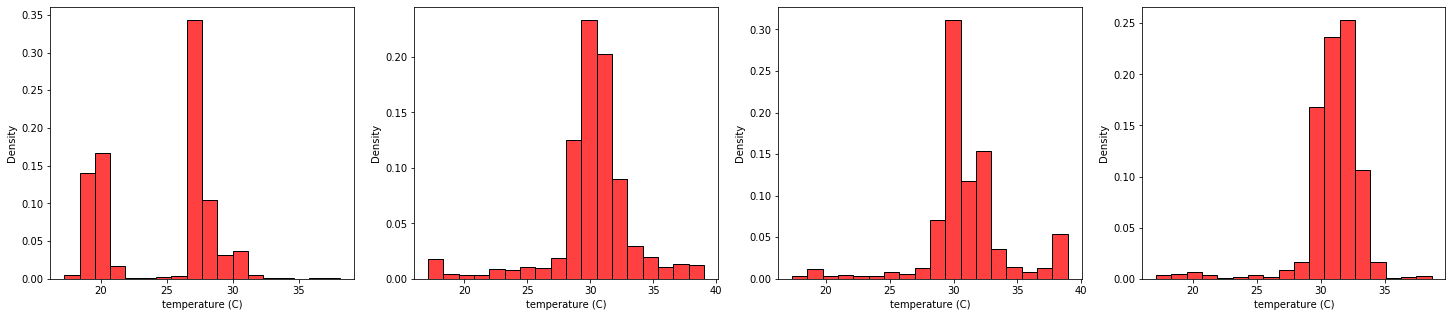

In [144]:
# c = ['c', 'y', 'm', 'k']
i = 0

fig, axes = plt.subplots(1, 4, figsize=(25, 5))

for ind in individuals:
        sns.histplot(ax=axes[i], data=df[scorer, ind, 'head'], x='temp', color='r', bins=18, stat="density")
        ax=axes[i]
        ax.set_xlabel('temperature (C)')
        i += 1
        

### Above, time spent at a specific temperature for the 4 animals in experiment 12082019_64656667-1

This is using the coordinate of the head